## Setup and imports


In [1]:
print('go')
import optim_esm_tools as oet
%run ../amoc_collapse_scripts/imports.py
from amoc_collapse_scripts import amoc_deep_dive, path_setup

go


In [2]:
from netCDF4 import Dataset

Smooth the time series using this gaussian filter

In [3]:
def gausian_filter(y, n=100, mu=7.5):
    b = gaussian(n, mu)
    gauss = scipy.ndimage.convolve1d(y, b / b.sum())
    return gauss


smoother = partial(gausian_filter, mu=3)

In [4]:
base = path_setup.MIXED_LAYER_BASE

figures_folder = os.path.join(base, "paper", "v2024.09.05_paper")
save_kw = dict(save_in=figures_folder, dpi=300, file_types=("png",))

### load the data

In [5]:
ds = Dataset(path_setup.EN4_MLD_DATA_SET, "r", format="NETCDF4")
kw = {
    k: (("lat", "lon"), np.array(ds[k]))
    for k in "mean_mld mask_IS mask_NS mask_LS mask_CB".split()
}
d_mld = xr.Dataset(
    data_vars=kw,
    coords=dict(
        lat=("lat", np.array(ds["lat"]).mean(axis=1)),
        lon=("lon", np.array(ds["lon"]).mean(axis=0)),
    ),
)
d_mld = d_mld.sortby("lon")

In [6]:
ts_mld = oet.load_glob(path_setup.EN4_MLD_TIME_SERIES)
ts_sss = oet.load_glob(path_setup.EN4_SSS_TIME_SERIES)

### Plotting setup

In [7]:
yearly_kw = dict(alpha=0.3)

In [8]:
oet.utils.setup_plt()

In [9]:
global_color_dict = {
    "Nordic Seas": "#e41a1c",
    "Irminger Sea": "#ff7f00",
    "Labrador Sea": "#a65628",
    "Cold blob": [mpl.colors.to_hex(c) for c in plt.cm.tab20.colors][16],
}

## The figure

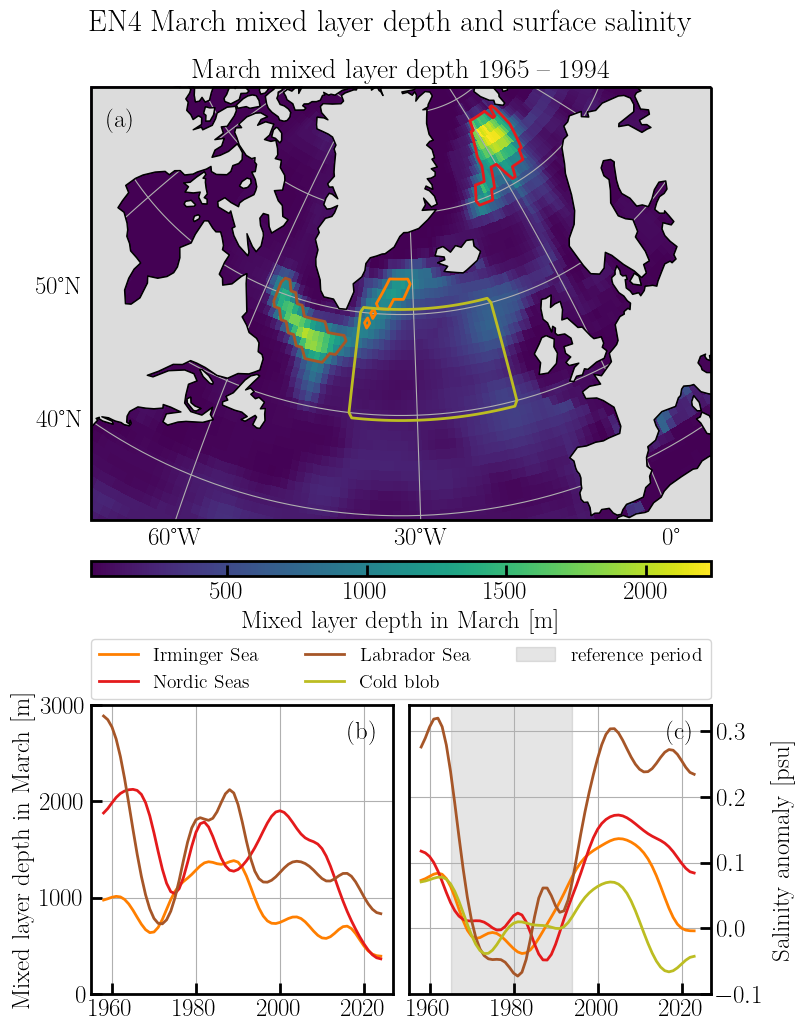

In [10]:
xmin, xmax = -70, 5
ymin, ymax = 33, 81
yoff = 2
w_space = 0.05
projection = "LambertAzimuthalEqualArea"
map_kw = dict(
    projection=oet.plotting.plot.get_cartopy_projection(
        projection=projection,
        central_longitude=(xmin + xmax) / 2,
        central_latitude=(ymin + ymax) / 2,
    )
)

fig, axes = plt.subplot_mosaic(
    "aa\n..\nbc",
    figsize=(8, 12),
    height_ratios=[3, 0.0, 1.5],
    width_ratios=[1, 1],
    gridspec_kw=dict(hspace=0.1, wspace=w_space),
    per_subplot_kw=dict(a=map_kw),
)

cmap = mpl.cm.viridis
kw = dict(
    add_colorbar=True,
    cmap=cmap,
    cbar_kwargs=dict(
        orientation="horizontal",
        aspect=40,
        pad=0.07,
        label=f"Mixed layer depth in March [m]",
    ),
)
for k in "a":
    ax = axes[k]
    off = 0
    ax.set_extent([xmin - off, xmax + off, ymin, ymax])
    ax.add_feature(
        cfeature.NaturalEarthFeature(
            "physical", "land", "110m", edgecolor="k", facecolor="gainsboro", zorder=2
        )
    )
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, zorder=1)
    gl.top_labels = False
    gl.right_labels = False

plt.sca(axes["a"])

d_mld = d_mld.copy()
v = d_mld["mean_mld"]
v.data[(v > 1e5).values] = np.nan


v.plot(transform=oet.plotting.plot.get_cartopy_transform(), **kw)
for key in global_color_dict.keys():

    amoc_deep_dive.overlay_contour(
        (d_mld[f"mask_{key[0]}S" if "Cold" not in key else "mask_CB"] > 0).astype(
            np.float32
        ),
        levels=[0.5, 1.5],
        linewidths=2,
        colors=global_color_dict[key],
        zorder=2,
        transform=oet.plotting.plot.get_cartopy_transform(),
    )
plt.title("March mixed layer depth 1965 -- 1994")

plt.sca(axes["b"])
ts_mld = ts_mld.sel(year=slice(1958, None))
plt.plot(
    ts_mld["year"],
    smoother(ts_mld["mld_IS"]),
    label="Irminger Sea",
    c=global_color_dict["Irminger Sea"],
)
plt.plot(
    ts_mld["year"],
    smoother(ts_mld["mld_NS"]),
    label="Nordic Seas",
    c=global_color_dict["Nordic Seas"],
)
plt.plot(
    ts_mld["year"],
    smoother(ts_mld["mld_LS"]),
    label="Labrador Sea",
    c=global_color_dict["Labrador Sea"],
)
plt.ylim(0, 3000)
plt.xlim(1957 - yoff, 2025 + yoff)
plt.ylabel("Mixed layer depth in March [m]")

plt.sca(axes["c"])
plt.ylabel("Surface salinity")
ts_sss = ts_sss.sel(year=slice(1958, None))
ref = ts_sss.copy().sel(year=slice(1965, 1994)).mean("year")
plt.plot(
    ts_sss["year"],
    smoother(ts_sss["SSS_IS"] - ref["SSS_IS"]),
    label="Irminger Sea",
    c=global_color_dict["Irminger Sea"],
)
plt.plot(
    ts_sss["year"],
    smoother(ts_sss["SSS_NS"] - ref["SSS_NS"]),
    label="Nordic Seas",
    c=global_color_dict["Nordic Seas"],
)
plt.plot(
    ts_sss["year"],
    smoother(ts_sss["SSS_LS"] - ref["SSS_LS"]),
    label="Labrador Sea",
    c=global_color_dict["Labrador Sea"],
)

plt.plot(
    ts_sss["year"],
    smoother(ts_sss["SSS_CB"] - ref["SSS_CB"]),
    label="Cold blob",
    c=global_color_dict["Cold blob"],
)
plt.axvspan(1965, 1994, alpha=0.1, color="k", label="reference period")
plt.ylabel("Salinity anomaly [psu]")
plt.legend(
    **oet.utils.legend_kw(
        ncol=3,
        bbox_to_anchor=(-1 - w_space, 1.02, 2 + w_space, 0.32),
    )
)
plt.ylim(-0.1, None)
plt.suptitle("EN4 March mixed layer depth and surface salinity", y=0.93)
plt.xlim(1957 - yoff, 2025 + yoff)
axes["c"].yaxis.tick_right()
axes["c"].yaxis.set_label_position("right")


for k in "abc":
    axes[k].text(
        0.05 if k == "a" else 0.90,
        0.95,
        f"({k})",
        va="top",
        ha="center",
        transform=axes[k].transAxes,
    )

oet.utils.save_fig(f"en4_data", **save_kw, sub_dir="figure_4")